# CIFAR-10 classifier from nnBuilder

This is a simple implementation of a CIFAR-10 classifier using the nnBuilder framework. Trying to reproduce the network of https://www.tensorflow.org/tutorials/deep_cnn/ (Work in progress)

In [1]:
import tensorflow as tf
import numpy as np
import sys, os, seaborn
sys.path.append('../nnBuilder')
from nnLayer import *
from nnInput import *
from nnTrainer import *
from nnHandler import *
from _nnUtils import *

In [2]:
preprocessing=False #Slow, not working?
test_split_n=10 #Avoid OOM
data=Layer(x=None,type="CIFAR_10")
data_test=Layer(x=None,type="CIFAR_10",test=True)
preprocess_layers=[]
#preprocess_layers.append(dict(type="Batch_Random_Crop",shape=[24,24,3]))#Need fix for test
preprocess_layers.append(dict(type="Batch_Random_Horizontal_Flip"))
preprocess_layers.append(dict(type="Batch_Random_Brightness"))
preprocess_layers.append(dict(type="Batch_Random_Contrast"))
preprocess_layers.append(dict(type="Batch_Whitening"))
preprocess_layers.append(dict(type="Pipeline",num_threads=8))
batch=Layer(x=data,type="Batch_Slice",batch=128,out_features=preprocessing and preprocess_layers or None)
batch_test=Layer(x=data_test,type="Batch_Slice",batch=10000//test_split_n)
layers=[]
layers.append(dict(type="Convolution",pad="SAME",window=5,stride=1,size=64,relu=True,out_features=[
              dict(type="Pool",pad="SAME",window=3,stride=2,pool_type="max"),
              dict(type="Local_Response_Norm")]))
layers.append(dict(type="Convolution",pad="SAME",window=5,stride=1,size=64,relu=True,out_features=[
              dict(type="Pool",pad="SAME",window=3,stride=2,pool_type="max"),
              dict(type="Local_Response_Norm")]))
layers.append(dict(type="Relu",size=384))
layers.append(dict(type="Relu",size=192))
layers.append(dict(type="Linear",size=10,in_features=["Dropout"]))
network_def=dict(type="Network",layers=layers)
network=Layer(x=batch,**network_def)
network_test=network.copy(x=batch_test,share_vars=True)
trainer=ClassifierTrainer(network=network,optimizer="adam",finish=True)
tester=ClassifierTrainer(network=network_test,optimizer="adam",finish=True,test=True)
sess=SessManager(data,batch,network,trainer,data_test,network_test,tester)#,input_network)
sess.start()

Starting new session


Error rate (train): 0.889844
Error rate (test): 0.888


<IPython.core.display.Javascript object>


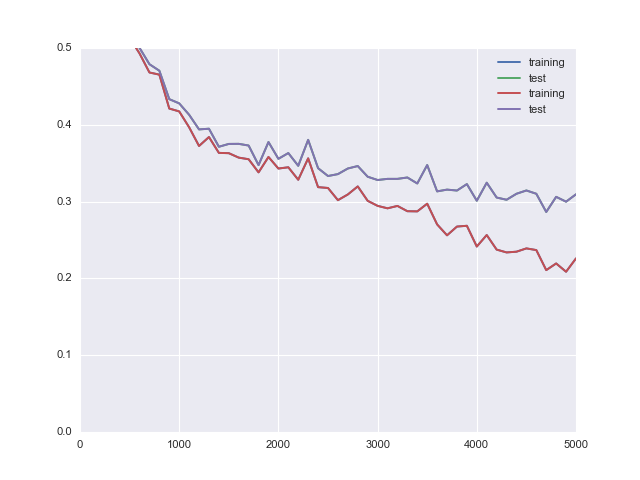

In [3]:
keep_rate=.5#Too slow with dropout
batches_per_step=100
def make_plt():
    %matplotlib notebook
    global train_plot, test_plot, fig,ax
    fig,ax = plt.subplots(1,1)
    train_plot=ax.plot([],[], label="training")[0]
    test_plot=ax.plot([],[], label="test")[0]
    ax.set_ylim(0,1)
    plt.legend()
def update_plt():
    x=[batches_per_step*i for i in range(len(trains))]
    train_plot.set_xdata(x)
    train_plot.set_ydata(trains)
    test_plot.set_xdata(x)
    test_plot.set_ydata(tests)
    ax.set_xlim(0,x[-1])
    fig.canvas.draw()
trainer.train(0,keep_rate=1.)
trains=[trainer.eval_error()[1]]#Initial Error rate
tests=[tester.eval_error()[1]]
make_plt()
for i in range(50):
    trainer.train(batches_per_step,keep_rate=keep_rate)
    trainer.train(0,keep_rate=1.)#To eval without dropout, fix needed
    trains.append(trainer.eval_error(n=100,print_=False)[1]) #Training error
    tests.append(tester.eval_error(n=test_split_n,print_=False)[1]) #Testing error
    update_plt()

In [4]:
#Plot the training and testing error rates (add more steps to see overfitting)
x=[batches_per_step*i for i in range(len(trains))]
plt.plot(x,trains, label="training")
plt.plot(x,tests, label="test")
plt.legend()
plt.ylim(0, .5)
plt.show()

In [5]:
network.save() #The full network definition
save=network.save() #The full network definition
assert(Layer(x=batch,**save).save()==save) #Consistency
print(save==network_def) #Saving adds stuff, should still be equivalent
save

False


{'layers': [{'input_channels': None,
   'out_features': [{'pad': 'SAME',
     'pool_type': 'max',
     'stride': 2,
     'type': 'Pool',
     'window': 3},
    {'type': 'Local_Response_Norm'}],
   'pad': 'SAME',
   'rand_scale': 0.1,
   'relu': True,
   'size': 64,
   'stride': 1,
   'type': 'Convolution',
   'window': 5},
  {'input_channels': None,
   'out_features': [{'pad': 'SAME',
     'pool_type': 'max',
     'stride': 2,
     'type': 'Pool',
     'window': 3},
    {'type': 'Local_Response_Norm'}],
   'pad': 'SAME',
   'rand_scale': 0.1,
   'relu': True,
   'size': 64,
   'stride': 1,
   'type': 'Convolution',
   'window': 5},
  {'rand_scale': 0.1, 'size': 384, 'type': 'Relu'},
  {'rand_scale': 0.1, 'size': 192, 'type': 'Relu'},
  {'in_features': [{'type': 'Dropout'}],
   'rand_scale': 0.1,
   'size': 10,
   'type': 'Linear'}],
 'type': 'Network'}